<a href="https://colab.research.google.com/github/R1chardJr/identifydrowsydrivers/blob/main/codeRichardRdoNJr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#instalando a biblioteca opendatasets para poder instalar a base de dados encontrada no kaggle para o trabalho
!pip install opendatasets

In [ ]:
import os
import shutil
import cv2
import random
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
tf.random.set_seed(3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import save_model
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import opendatasets as od

dataset = 'https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/data'

od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: richardjunior
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd


100%|██████████| 2.58G/2.58G [02:10<00:00, 21.2MB/s]


In [ ]:
#instalando biblioteca para dividir nossa base de dados
!pip install split-folders

(Parte 1)treinando e preparando primeira base e primeiro modelo

In [ ]:
import splitfolders

#dividindo a base de dados em 80% para treino e 20% para teste

data_dir = '/content/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)'
output_dir = '/content/driver-drowsiness-dataset-ddd/working_area'
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.2))

Copying files: 41793 files [00:29, 1398.78 files/s]


In [ ]:
train_dir = '/content/driver-drowsiness-dataset-ddd/working_area/train'
test_dir = '/content/driver-drowsiness-dataset-ddd/working_area/val'

In [ ]:
#processo para normalizar as imagens,preparando os dados
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#normalizando os dados do treino
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

#normalizando os dados do teste
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

In [ ]:
#Checando os dados
#extraindo os indices das classes
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices

#extraindo o rotulo das classes
train_class_labels = train_batches.classes
test_class_labels = test_batches.classes

#extraindo a quantidade que há em cada classe
train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)

#imprimindo os resultados
print("Nome das classes em treino:\n", train_class_indices)
print("Quantidade de imagens no treino:\n", train_class_counts)
print('\n')

print("Nome das classes em teste:\n", test_class_indices)
print("Quantidade de imagens no teste:\n", test_class_counts)

Nome das classes em treino:
 {'Drowsy': 0, 'Non Drowsy': 1}
Quantidade de imagens no treino:
 Counter({0: 17878, 1: 15556})


Nome das classes em teste:
 {'Drowsy': 0, 'Non Drowsy': 1}
Quantidade de imagens no teste:
 Counter({0: 4470, 1: 3889})


Pixels da primeira imagem apos a normalizacao: 

[[[0.9490197  0.8862746  0.79215693]
  [0.9450981  0.882353   0.78823537]
  [0.94117653 0.882353   0.78823537]
  ...
  [0.40000004 0.3372549  0.24705884]
  [0.6117647  0.5529412  0.45882356]
  [0.86666673 0.7960785  0.70980394]]

 [[0.95294124 0.8941177  0.7960785 ]
  [0.9568628  0.8980393  0.7960785 ]
  [0.9450981  0.8862746  0.78823537]
  ...
  [0.3254902  0.2627451  0.16862746]
  [0.5764706  0.5137255  0.427451  ]
  [0.8431373  0.77647066 0.6901961 ]]

 [[0.9568628  0.8980393  0.8000001 ]
  [0.9568628  0.8980393  0.8000001 ]
  [0.95294124 0.8941177  0.79215693]
  ...
  [0.3137255  0.2509804  0.17254902]
  [0.6117647  0.54509807 0.46274513]
  [0.86666673 0.8000001  0.7176471 ]]

 ...

 [[0.20784315 0.09019608 0.03137255]
  [0.20392159 0.08235294 0.03137255]
  [0.20392159 0.08627451 0.04313726]
  ...
  [0.21960786 0.05490196 0.07843138]
  [0.2392157  0.06666667 0.09411766]
  [0.25882354 0.08235294 0.10588236]]

 [[0.19607845 0.08235294 

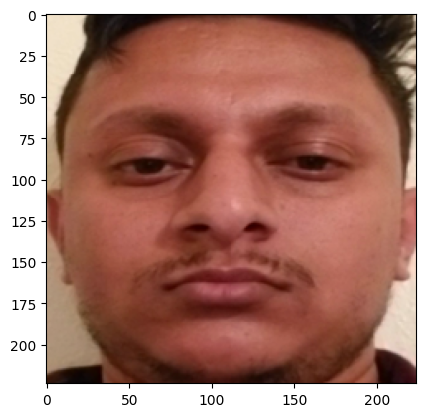

Ha 3 canais 
forma da imagem : (224, 224, 3)


In [ ]:
#checando o processo de normalizacao das imagens
images, labels = next(train_batches)
print(f"Pixels da primeira imagem apos a normalizacao: \n\n{images[0]}")
plt.imshow(images[0])
plt.show()

#checando a dimensao e a forma da imagem
print(f"Ha { images[0].ndim} canais ")
print(f"forma da imagem : {images[0].shape}")

In [ ]:
#carregando o modelo pre-treinado MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
)
base_model.trainable = False # para que as camadas nn sejam treinadas durante o fine-tuning

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
type(base_model)

keras.src.models.functional.Functional

In [ ]:
#um resumo de como funciona o modelo e suas camadas
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#construindo um modelo sequencial vazio do keras(ponto de partida)
model1=keras.Sequential() #vazio

In [ ]:
#congelando todas as camadas exceto as 25 ultimas,assim somente elas serao ajustadas durante o treinamento
#isso poruqe as primeiras camadas geralmente pegam caracteristicas mais gerais da imagem,enquanto as ultimas pegam caracteristicas mais especificas
for layer in base_model.layers[:-25] :
    layer.trainable = False

In [ ]:
#adicionando novas camadas,criando uma nova arquitetura da rede neural
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)#Dense(2, activation='softmax')

In [ ]:
#criando um modelo que combina o modelo base do MobileNetV2 com as camadas adicionadas acima
model1 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#resumo do modelo que personalizamos e suas camadas
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 67,009,601 (255.62 MB)

 Trainable params: 64,751,617 (247.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#compilando o modelo e as metricas para usar no treino
model1.compile(optimizer=Adam(0.0001 ), loss='binary_crossentropy', metrics=['accuracy',])

In [ ]:
#treinando o modelo
history1 = model1.fit(
   train_batches,
    epochs=5,
    validation_data=test_batches,
    batch_size=32
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 237s 100ms/step - accuracy: 0.9773 - loss: 0.0810 - val_accuracy: 0.9987 - val_loss: 0.0078
Epoch 2/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 204s 97ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.9943 - val_loss: 0.0502
Epoch 3/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 242s 88ms/step - accuracy: 0.9993 - loss: 0.0042 - val_accuracy: 0.9995 - val_loss: 0.0043
Epoch 4/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 196s 94ms/step - accuracy: 0.9985 - loss: 0.0136 - val_accuracy: 0.9993 - val_loss: 0.0069
Epoch 5/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 190s 91ms/step - accuracy: 0.9996 - loss: 0.0035 - val_accuracy: 0.9995 - val_loss: 0.0045


In [ ]:
from tensorflow.keras.models import save_model

save_model(model1, 'primeiroteste.h5') # Use save_model from tensorflow.keras.models

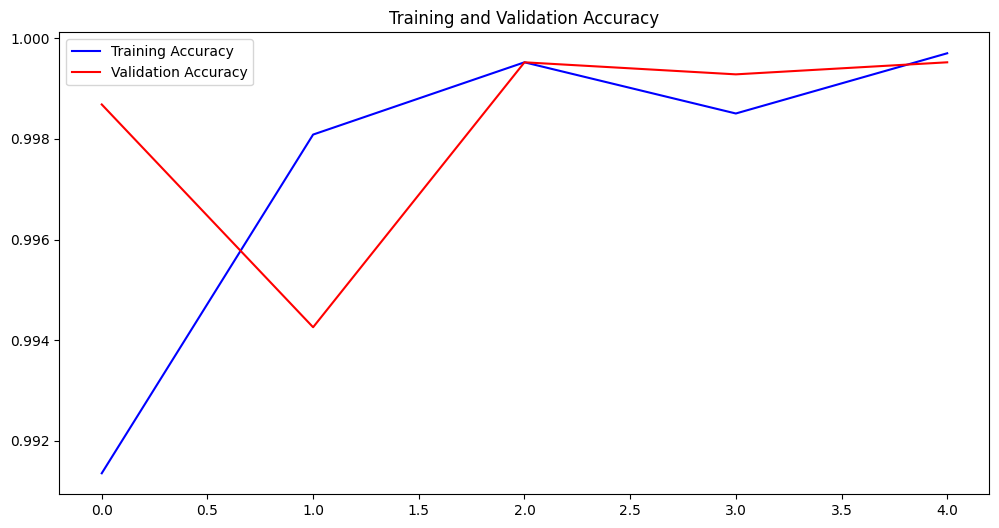

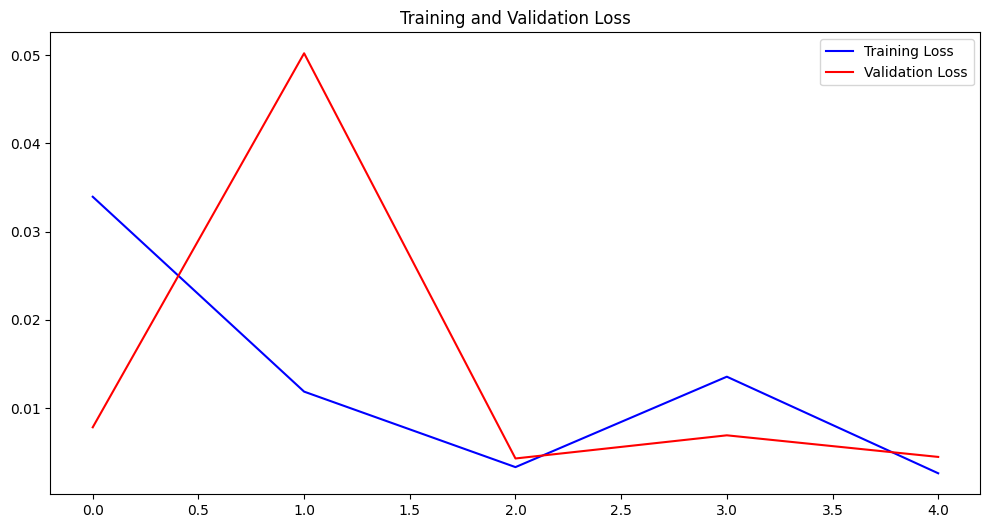

In [ ]:
# Obtendo as métricas do histórico de treinamento
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(accuracy))

# Gráfico de Acurácia
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, "b", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig('Graficoacuracia1')
plt.show()

# Gráfico de Perda
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig('Graficoperda1')
plt.show()


(Parte 2)treinando e preparando segunda base e segundo modelo


In [ ]:
#indicando os datasets de acordo com o caminho no drive
dataset2 ='/content/drive/MyDrive/dataset2'
dataset2apoio = '/content/drive/MyDrive/datasetapoio'

In [ ]:
#verificando os rotulos do segundo dataset
labels = os.listdir("/content/drive/MyDrive/dataset2/train")
labels

['no_yawn', 'yawn']

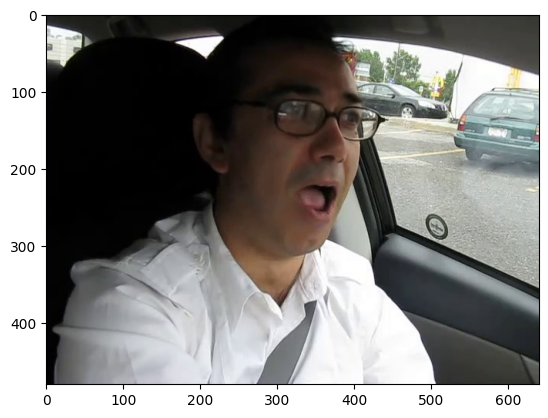

In [ ]:
#verificando uma imagem
plt.imshow(plt.imread("/content/drive/MyDrive/dataset2/train/yawn/110.jpg"))

In [ ]:
#preparando os dados,especificamente os rostos para o processo
def face_for_yawn(direc="/content/drive/MyDrive/dataset2/train", face_cas_path="/content/drive/MyDrive/datasetapoio/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                if roi_color.size != 0:
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))

                    yaw_no.append([resized_array.flatten(), class_num1])
                else:
                    print(f"Failed to extract face from {os.path.join(path_link, image)}")
    images = np.array([item[0] for item in yaw_no])
    labels = np.array([item[1] for item in yaw_no])
    return images, labels

images, labels = face_for_yawn()

0
1


In [ ]:
X = images
y = labels


In [ ]:
#redimensionando as imagens
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
#convertendo os rótulos de categorias para uma representação binária
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)

In [ ]:
#separando porcao de treino(80%) e porcao de teste(20%)
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)

95

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
#fazendo 'data augmentation' com os dados
train_generator2 = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator2 = ImageDataGenerator(rescale=1/255)

X_train = np.array(X_train)
X_test = np.array(X_test)

#verificando que sejam arrays do numpy
y_train = np.array(y_train)
y_test = np.array(y_test)

train_generator = train_generator2.flow(np.array(X_train), y_train, shuffle=True)
test_generator = test_generator2.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
#modelando o modelo 2 usando a arquitetura sequential do keras
model2 = Sequential()

model2.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model2.add(MaxPooling2D(2, 2))

model2.add(Conv2D(128, (3, 3), activation="relu"))
model2.add(MaxPooling2D(2, 2))

model2.add(Conv2D(64, (3, 3), activation="relu"))
model2.add(MaxPooling2D(2, 2))

model2.add(Conv2D(32, (3, 3), activation="relu"))
model2.add(MaxPooling2D(2, 2))

model2.add(Flatten())
model2.add(Dropout(0.5))

model2.add(Dense(64, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 69, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,945 (1.89 MB)

 Trainable params: 494,945 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
type(model2)

keras.src.models.sequential.Sequential

In [ ]:
#treinando o modelo
validation_steps = len(X_test) // 32

history2 = model2.fit(train_generator, epochs=30,
                    validation_data=test_generator,
                    shuffle=True,
                    validation_steps=validation_steps)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4920 - loss: 0.7146 - val_accuracy: 0.5469 - val_loss: 0.6903
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.5492 - loss: 0.6918 - val_accuracy: 0.3871 - val_loss: 0.6953
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5544 - loss: 0.6569 - val_accuracy: 0.6719 - val_loss: 0.6277
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.7307 - loss: 0.5534 - val_accuracy: 0.7097 - val_loss: 0.6542
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7078 - loss: 0.5593 - val_accuracy: 0.6875 - val_loss: 0.5638
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.7706 - loss: 0.4871 - val_accuracy: 0.7742 - val_loss: 0.4977
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.7658 - loss: 0.4962 - val_accuracy: 0.7969 - val_loss: 0.5364
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.7775 - loss: 0.4725 - val_accuracy: 0.8065 - val_loss: 0.4647
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.7817 - loss: 0.4489 - val_accuracy: 0.8281 - val_loss: 0.3735
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7803 - loss: 0.4736 - val_accuracy: 0.9032 - val

In [ ]:
#salvando o modelo ja treinado para facilitar depois
model2.save('segundoteste.h5')

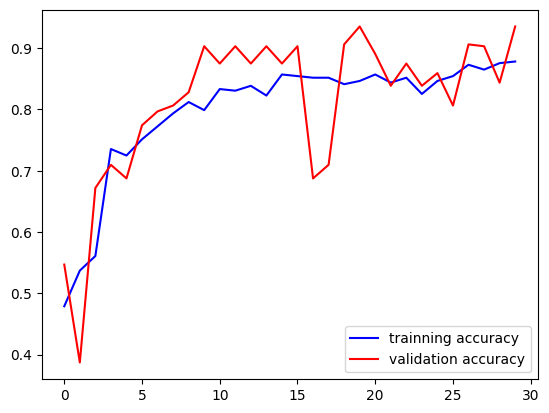

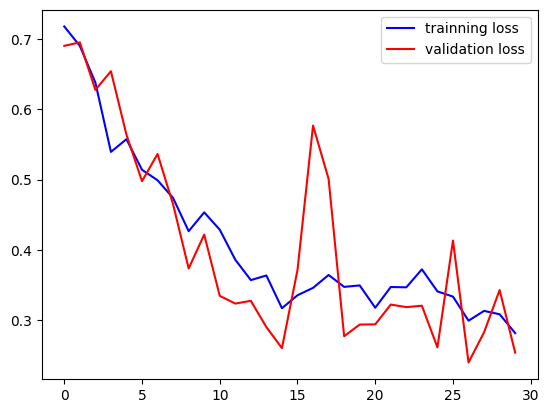

In [ ]:
# Obtendo as métricas do histórico de treinamento
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(accuracy))

# Gráfico de Acurácia
plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.savefig('Graficoacuracia2')
plt.show()

# Gráfico de Perda
plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.savefig('Graficoperda2')
plt.show()

(Parte 3)usando o treino e modelo da base 1 para testar com o teste da base 2


In [ ]:
#carregando o modelo treinado e testado na base 1
model1 = tf.keras.models.load_model('/content/drive/MyDrive/PrimeiroTeste.h5')

In [ ]:
#comeco do tratamento dos dados,separando a base 2 da mesma forma feita na base um para usarmos o conjunto de teste
import splitfolders

data_dir = '/content/drive/MyDrive/dataset2/train'
output_dir = '/content/driver-drowsiness-dataset-ddd/working_area2'
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.2))

Copying files: 1458 files [00:45, 31.71 files/s] 


In [ ]:
test_dir2 = '/content/driver-drowsiness-dataset-ddd/working_area2/val'

#normalizando os dados do teste da base 2 para se adequar ao modelo 1
test_datagen2 = ImageDataGenerator(rescale=1./255)

test_batches2 = test_datagen2.flow_from_directory(
    test_dir2,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True,
    classes=['no_yawn', 'yawn']
)

Found 292 images belonging to 2 classes.


In [ ]:
#recompilando o modelo 1
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#fazendo o teste dos dados da base 2 no modelo treinado com a base 1
history3 = model1.fit(
   train_batches,
    epochs=5,
    validation_data=test_batches2,
    batch_size=32
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 179s 80ms/step - accuracy: 0.9895 - loss: 0.2372 - val_accuracy: 0.4658 - val_loss: 11.4907
Epoch 2/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 144s 69ms/step - accuracy: 0.9963 - loss: 0.0671 - val_accuracy: 0.4760 - val_loss: 9.5998
Epoch 3/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 205s 70ms/step - accuracy: 0.9994 - loss: 0.0064 - val_accuracy: 0.5034 - val_loss: 18.0936
Epoch 4/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 140s 67ms/step - accuracy: 0.9992 - loss: 0.0115 - val_accuracy: 0.5034 - val_loss: 8.6801
Epoch 5/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 139s 65ms/step - accuracy: 0.9994 - loss: 0.0036 - val_accuracy: 0.5034 - val_loss: 9.4901


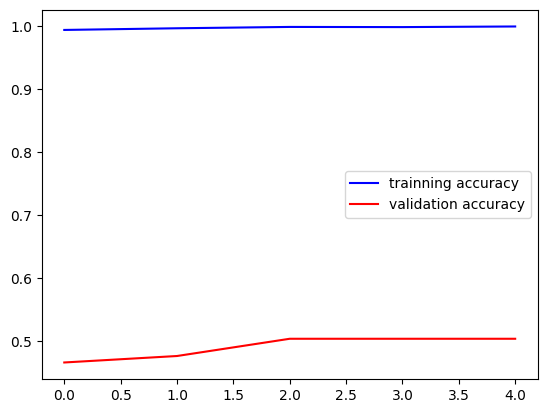

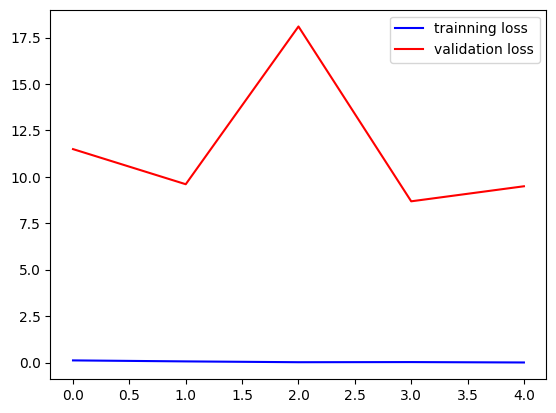

In [ ]:
# Obtendo as métricas do histórico de treinamento
accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(len(accuracy))

# Gráfico de Acurácia
plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.savefig('Graficoacuracia3')
plt.show()

# Gráfico de Perda
plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.savefig('Graficoperda3')
plt.show()

In [ ]:
loss, accuracy = model1.evaluate(test_batches2)
print("Loss:", loss)
print("Accuracy:", accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.4565 - loss: 8.5625
Loss: 8.873912811279297
Accuracy: 0.4383561611175537


(Parte 4)usando o treino da base 1 para testar com o modelo e teste da base 2


In [ ]:
#carregando o modelo treinado e testado na base 2
model2 = tf.keras.models.load_model('/content/drive/MyDrive/segundoteste.h5')

In [ ]:
#recompilando o modelo 2
model2.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
#preparando os dados,especificamente os rostos para o processo
def face_for_yawn(direc="/content/driver-drowsiness-dataset-ddd/working_area/val", face_cas_path="/content/drive/MyDrive/datasetapoio/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["Drowsy","Non Drowsy"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                if roi_color.size != 0:
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    yaw_no.append([resized_array.flatten(), class_num1])
                else:
                    print(f"Failed to extract face from {os.path.join(path_link, image)}")
    images = np.array([item[0] for item in yaw_no])
    labels = np.array([item[1] for item in yaw_no])
    return images, labels

Images, Labels = face_for_yawn()

0
1


In [ ]:
X = Images
y = Labels

X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

y = np.array(y)

In [ ]:
X = X_test
y = y_test

In [ ]:
test_generator2 = ImageDataGenerator(rescale=1/255)

test_generator = test_generator2.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
#fazendo o teste dos dados da base 1 no modelo treinado com a base 2
validation_steps = len(X_test) // 32

history4 = model2.fit(train_generator, epochs=20,
                    validation_data=test_generator,
                    shuffle=True,
                    validation_steps=validation_steps)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8575 - loss: 0.3105 - val_accuracy: 0.9219 - val_loss: 0.2080
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8940 - loss: 0.2514

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 560ms/step - accuracy: 0.8940 - loss: 0.2522 - val_accuracy: 0.7742 - val_loss: 0.4728
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8835 - loss: 0.2810 - val_accuracy: 0.9531 - val_loss: 0.1893
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.8594 - loss: 0.2798 - val_accuracy: 0.8065 - val_loss: 0.4013
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8707 - loss: 0.2617 - val_accuracy: 0.9062 - val_loss: 0.1888
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8863 - loss: 0.2669 - val_accuracy: 0.9032 - val_loss: 0.2162
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.8899 - loss: 0.2755 - val_accuracy: 0.7656 - val_loss: 0.5738
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8510 - loss: 0.3374 - val_accuracy: 0.8710 - val_loss: 0.2961
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9209 - loss: 0.2248 - val_accuracy: 0.9219 - val_

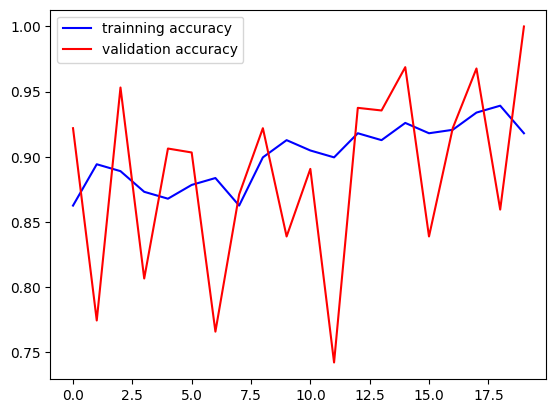

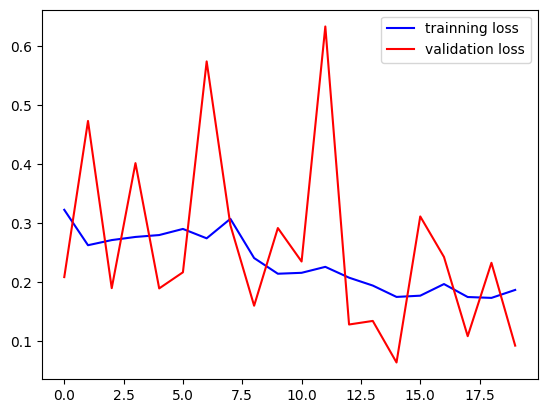

In [ ]:
# Obtendo as métricas do histórico de treinamento
accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(len(accuracy))

# Gráfico de Acurácia
plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.savefig('Graficoacuracia4')
plt.show()

# Gráfico de Perda
plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.savefig('Graficoperda4')
plt.show()

In [ ]:
test_datagen_1 = ImageDataGenerator(rescale=1./255)
test_batches_1 = test_datagen_1.flow_from_directory(
    test_dir,
    target_size=(145, 145),
    batch_size=16,
    class_mode='binary'
)

Found 8359 images belonging to 2 classes.


In [ ]:
loss, accuracy = model2.evaluate(test_batches_1)
print("Loss on dataset1:", loss)
print("Accuracy on dataset1:", accuracy)

523/523 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step - accuracy: 0.4295 - loss: 1.2002
Loss on dataset1: 1.1815904378890991
Accuracy on dataset1: 0.43175020813941956


(Parte 5)Juntando as duas bases para formar uma unica base

In [ ]:
#verificando a quantidade de itens em cada base
diretorio = '/content/driver-drowsiness-dataset-ddd/working_area/train/Drowsy'
quantidade_itens = len(os.listdir(diretorio))
print(f"O diretório da base 1 '{diretorio}' contém {quantidade_itens} itens.")
diretorio = '/content/driver-drowsiness-dataset-ddd/working_area/train/Non Drowsy'
quantidade_itens = len(os.listdir(diretorio))
print(f"O diretório da base 1 '{diretorio}' contém {quantidade_itens} itens.")

diretorio = '/content/driver-drowsiness-dataset-ddd/working_area2/train/yawn'
quantidade_itens = len(os.listdir(diretorio))
print(f"O diretório da base 2 '{diretorio}' contém {quantidade_itens} itens.")
diretorio = '/content/driver-drowsiness-dataset-ddd/working_area2/train/no_yawn'
quantidade_itens = len(os.listdir(diretorio))
print(f"O diretório da base 2 '{diretorio}' contém {quantidade_itens} itens.")

Como vemos existe uma grande diferenca ainda de imagens de cada dataset, entao iremos fazer o processo de data augmentation na segunda base

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

output_dir = '/content/driver-drowsiness-dataset-ddd/working_area2/train/yawn'
os.makedirs(output_dir, exist_ok=True)

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

i = 0
for batch in datagen.flow_from_directory(
    '/content/driver-drowsiness-dataset-ddd/working_area2/train',
    target_size=(224, 224),
    batch_size=1,
    classes=['yawn'],
    save_to_dir=output_dir,
    save_prefix='augmented_',
    save_format='jpg'
):
    i += 1
    if i > 400: # Defina quantas imagens gerar
        break

Found 578 images belonging to 1 classes.


In [ ]:
output_dir = '/content/driver-drowsiness-dataset-ddd/working_area2/train/no_yawn'

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

i = 0
for batch in datagen.flow_from_directory(
    '/content/driver-drowsiness-dataset-ddd/working_area2/train',
    target_size=(224, 224),
    batch_size=1,
    classes=['no_yawn'],
    save_to_dir=output_dir,
    save_prefix='augmented_',
    save_format='jpg'
):
    i += 1
    if i > 400:
        break

Found 588 images belonging to 1 classes.


In [ ]:
output_dir = '/content/driver-drowsiness-dataset-ddd/working_area2/val/yawn'
os.makedirs(output_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

i = 0
for batch in datagen.flow_from_directory(
    '/content/driver-drowsiness-dataset-ddd/working_area2/val',
    target_size=(224, 224),
    batch_size=1,
    classes=['yawn'],
    save_to_dir=output_dir,
    save_prefix='augmented_',
    save_format='jpg'
):
    i += 1
    if i > 400:
        break

Found 145 images belonging to 1 classes.


In [ ]:
output_dir = '/content/driver-drowsiness-dataset-ddd/working_area2/val/no_yawn'

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

i = 0
for batch in datagen.flow_from_directory(
    '/content/driver-drowsiness-dataset-ddd/working_area2/val',
    target_size=(224, 224),
    batch_size=1,
    classes=['no_yawn'],
    save_to_dir=output_dir,
    save_prefix='augmented_',
    save_format='jpg'
):
    i += 1
    if i > 400:
        break

Found 147 images belonging to 1 classes.


In [ ]:
diretorio = '/content/driver-drowsiness-dataset-ddd/working_area2/train/yawn'
quantidade_itens = len(os.listdir(diretorio))
print(f"O diretório da base 2 '{diretorio}' contém {quantidade_itens} itens.")
diretorio = '/content/driver-drowsiness-dataset-ddd/working_area2/train/no_yawn'
quantidade_itens = len(os.listdir(diretorio))
print(f"O diretório da base 2 '{diretorio}' contém {quantidade_itens} itens.")

O diretório da base 2 '/content/driver-drowsiness-dataset-ddd/working_area2/train/yawn' contém 979 itens.
O diretório da base 2 '/content/driver-drowsiness-dataset-ddd/working_area2/train/no_yawn' contém 989 itens.


Alem disso retiramos algumas imagens da primeira base para manter melhor proporcao entre as quantidades de imagens das bases

In [ ]:
diretorio_drowsy = '/content/driver-drowsiness-dataset-ddd/working_area/train/Drowsy'
diretorio_non_drowsy = '/content/driver-drowsiness-dataset-ddd/working_area/train/Non Drowsy'
fracao_excluir = 0.89 #deixando apenas 11% das imagens para melhor proporcao

# Excluir imagens do diretório 'Drowsy'
imagens_drowsy = os.listdir(diretorio_drowsy)
num_excluir_drowsy = int(len(imagens_drowsy) * fracao_excluir)
imagens_excluir_drowsy = random.sample(imagens_drowsy, num_excluir_drowsy)
for imagem in imagens_excluir_drowsy:
    caminho_imagem = os.path.join(diretorio_drowsy, imagem)
    os.remove(caminho_imagem)

# Excluir imagens do diretório 'Non Drowsy'
imagens_non_drowsy = os.listdir(diretorio_non_drowsy)
num_excluir_non_drowsy = int(len(imagens_non_drowsy) * fracao_excluir)
imagens_excluir_non_drowsy = random.sample(imagens_non_drowsy, num_excluir_non_drowsy)
for imagem in imagens_excluir_non_drowsy:
    caminho_imagem = os.path.join(diretorio_non_drowsy, imagem)
    os.remove(caminho_imagem)


In [ ]:
diretorio_drowsy = '/content/driver-drowsiness-dataset-ddd/working_area/val/Drowsy'
diretorio_non_drowsy = '/content/driver-drowsiness-dataset-ddd/working_area/val/Non Drowsy'
fracao_excluir = 0.89

# Excluir imagens do diretório 'Drowsy'
imagens_drowsy = os.listdir(diretorio_drowsy)
num_excluir_drowsy = int(len(imagens_drowsy) * fracao_excluir)
imagens_excluir_drowsy = random.sample(imagens_drowsy, num_excluir_drowsy)
for imagem in imagens_excluir_drowsy:
    caminho_imagem = os.path.join(diretorio_drowsy, imagem)
    os.remove(caminho_imagem)

# Excluir imagens do diretório 'Non Drowsy'
imagens_non_drowsy = os.listdir(diretorio_non_drowsy)
num_excluir_non_drowsy = int(len(imagens_non_drowsy) * fracao_excluir)
imagens_excluir_non_drowsy = random.sample(imagens_non_drowsy, num_excluir_non_drowsy)
for imagem in imagens_excluir_non_drowsy:
    caminho_imagem = os.path.join(diretorio_non_drowsy, imagem)
    os.remove(caminho_imagem)

In [ ]:
diretorio = '/content/driver-drowsiness-dataset-ddd/working_area/train/Drowsy'
quantidade_itens = len(os.listdir(diretorio))
print(f"O diretório da base 1 '{diretorio}' contém {quantidade_itens} itens.")
diretorio = '/content/driver-drowsiness-dataset-ddd/working_area/train/Non Drowsy'
quantidade_itens = len(os.listdir(diretorio))
print(f"O diretório da base 1 '{diretorio}' contém {quantidade_itens} itens.")

O diretório da base 1 '/content/driver-drowsiness-dataset-ddd/working_area/train/Drowsy' contém 1967 itens.
O diretório da base 1 '/content/driver-drowsiness-dataset-ddd/working_area/train/Non Drowsy' contém 1712 itens.


Agora que temos uma proporcao melhor vamos juntar as duas bases

In [ ]:
# Diretório da primeira base
base1_dir = '/content/driver-drowsiness-dataset-ddd/working_area'

# Diretório da segunda base
base2_dir = '/content/driver-drowsiness-dataset-ddd/working_area2'

# Diretório da base completa
base_completa_dir = 'base_completa'

# Crie a pasta da base completa se ela não existir
os.makedirs(base_completa_dir, exist_ok=True)

# Copie as imagens da base 1 para a base completa
if not os.path.exists(os.path.join(base_completa_dir, 'treino')):
    shutil.copytree(os.path.join(base1_dir, 'train'), os.path.join(base_completa_dir, 'treino'))
if not os.path.exists(os.path.join(base_completa_dir, 'teste')):
    shutil.copytree(os.path.join(base1_dir, 'val'), os.path.join(base_completa_dir, 'teste'))

# Copie as imagens da base 2 para a base completa, verificando se o diretório de destino já existe
# (Ajuste os caminhos conforme necessário)
if not os.path.exists(os.path.join(base_completa_dir, 'treino')):
    shutil.copytree(os.path.join(base2_dir, 'train'), os.path.join(base_completa_dir, 'treino'))
if not os.path.exists(os.path.join(base_completa_dir, 'teste')):
    shutil.copytree(os.path.join(base2_dir, 'val'), os.path.join(base_completa_dir, 'teste'))

In [ ]:
# Diretório da base completa
base_completa_dir = 'base_completa'

# Classes equivalentes
classes_equivalentes = {
    'Drowsy': ['Drowsy', 'yawn'],
    'Non Drowsy': ['Non Drowsy', 'no_yawn']
}

# Mova as imagens para as pastas corretas
for classe_final, classes_originais in classes_equivalentes.items():
    # Crie a pasta da classe final se ela não existir
    os.makedirs(os.path.join(base_completa_dir, 'treino', classe_final), exist_ok=True)
    os.makedirs(os.path.join(base_completa_dir, 'teste', classe_final), exist_ok=True)

    for classe_original in classes_originais:
        # Diretório da classe original na base 1
        base1_dir = '/content/driver-drowsiness-dataset-ddd/working_area'
        origem_base1_treino = os.path.join(base1_dir, 'train', classe_original)
        origem_base1_teste = os.path.join(base1_dir, 'val', classe_original)

        # Diretório da classe original na base 2
        base2_dir = '/content/drive/MyDrive/dataset2'
        origem_base2_treino = os.path.join(base2_dir, 'train', classe_original)
        origem_base2_teste = os.path.join(base2_dir, 'val', classe_original)

        # Destino na base completa
        destino_treino = os.path.join(base_completa_dir, 'treino', classe_final)
        destino_teste = os.path.join(base_completa_dir, 'teste', classe_final)

        # Copie as imagens da base 1
        if os.path.exists(origem_base1_treino):
            for arquivo in os.listdir(origem_base1_treino):
                shutil.copy(os.path.join(origem_base1_treino, arquivo), destino_treino)
        if os.path.exists(origem_base1_teste):
            for arquivo in os.listdir(origem_base1_teste):
                shutil.copy(os.path.join(origem_base1_teste, arquivo), destino_teste)

        # Copie as imagens da base 2
        if os.path.exists(origem_base2_treino):
            for arquivo in os.listdir(origem_base2_treino):
                shutil.copy(os.path.join(origem_base2_treino, arquivo), destino_treino)
        if os.path.exists(origem_base2_teste):
            for arquivo in os.listdir(origem_base2_teste):
                shutil.copy(os.path.join(origem_base2_teste, arquivo), destino_teste)

In [ ]:
labelstrain = os.listdir("/content/base_completa/treino")
labelstrain

['Drowsy', 'Non Drowsy']

In [ ]:
labelstest = os.listdir("/content/base_completa/teste")
labelstest

['Drowsy', 'Non Drowsy']

In [ ]:
train_dir5 = '/content/base_completa/treino'
test_dir5 = '/content/base_completa/teste'

#processo para normalizar as imagens,preparando os dados
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#normalizando os dados do treino
train_batches5 = train_datagen.flow_from_directory(
    train_dir5,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

#normalizando os dados do teste
test_batches5 = test_datagen.flow_from_directory(
    test_dir5,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

Found 5137 images belonging to 2 classes.
Found 920 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
#modelando o modelo 3 usando a arquitetura sequential do keras,ele se baseia no modelo 2
model3 = Sequential()

X_train_batch, _ = train_batches5.__next__()

input_shape = X_train_batch[0].shape

model3.add(Conv2D(256, (3, 3), activation="relu", input_shape=input_shape))
model3.add(MaxPooling2D(2, 2))

model3.add(Conv2D(128, (3, 3), activation="relu"))
model3.add(MaxPooling2D(2, 2))

model3.add(Conv2D(64, (3, 3), activation="relu"))
model3.add(MaxPooling2D(2, 2))

model3.add(Conv2D(32, (3, 3), activation="relu"))
model3.add(MaxPooling2D(2, 2))

model3.add(Flatten())
model3.add(Dropout(0.5))

model3.add(Dense(64, activation="relu"))
model3.add(Dense(1, activation="sigmoid"))

model3.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 689,505 (2.63 MB)

 Trainable params: 689,505 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history5 = model3.fit(
   train_batches5,
    epochs=7,
    validation_data=test_batches5,
    batch_size=32
)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 61s 150ms/step - accuracy: 0.5421 - loss: 0.6828 - val_accuracy: 0.8989 - val_loss: 0.3237
Epoch 2/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 61s 116ms/step - accuracy: 0.8133 - loss: 0.3676 - val_accuracy: 0.9772 - val_loss: 0.0570
Epoch 3/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.9018 - loss: 0.2001 - val_accuracy: 0.9957 - val_loss: 0.0136
Epoch 4/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.9238 - loss: 0.1548 - val_accuracy: 0.9935 - val_loss: 0.0255
Epoch 5/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.9355 - loss: 0.1419 - val_accuracy: 0.9967 - val_loss: 0.0164
Epoch 6/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 43s 122ms/step - accuracy: 0.9575 - loss: 0.0993 - val_accuracy: 0.9946 - val_loss: 0.0147
Epoch 7/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.9676 - loss: 0.0834 - val_accuracy: 0.9946 - val_loss: 0.0193


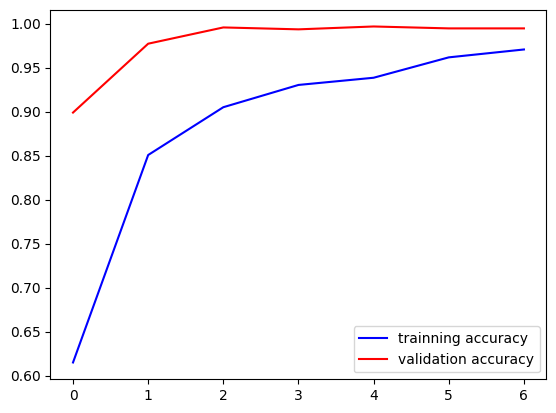

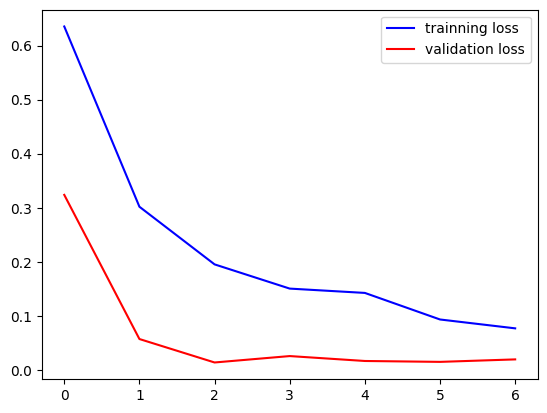

In [ ]:
# Obtendo as métricas do histórico de treinamento
accuracy = history5.history['accuracy']
val_accuracy = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs = range(len(accuracy))

# Gráfico de Acurácia
plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.savefig('Graficoacuracia5')
plt.show()

# Gráfico de Perda
plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.savefig('Graficoperda5')
plt.show()

(Parte 6)Usando agora um algoritmo de domain adaptation

In [ ]:
from tensorflow.keras import layers, models, optimizers

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Caminhos para os diretórios
train_dir = '/content/base_completa/treino'
test_dir = '/content/base_completa/teste'

# Criar o gerador de dados para treinamento e teste
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Gerador de dados para treinamento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Gerador de dados para teste
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 5137 images belonging to 2 classes.
Found 920 images belonging to 2 classes.


Comecando a moldar agora o algoritmo de domain adaptation DANN(Domain-Adversarial Neural Network)

In [ ]:
#parte do modelo que extrai as caracteristicas das imagens
def build_feature_extractor(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),  # Use um objeto Input aqui
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten()
    ])
    return model

In [ ]:
#parte do modelo que usa as caracteristicas extraidas para prever os rotulos
def build_label_predictor():
    model = models.Sequential([
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
#parte do modelo responsavel de prever de qual dominio as caracteristicas vem
def build_domain_classifier():
    model = models.Sequential([
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
#montando o DANN
class DANN(tf.keras.Model):
    def __init__(self, feature_extractor, label_predictor, domain_classifier, lambda_=1.0):
        super(DANN, self).__init__()
        self.feature_extractor = feature_extractor
        self.label_predictor = label_predictor
        self.domain_classifier = domain_classifier
        self.lambda_ = lambda_
        self.accuracy_metric = tf.keras.metrics.BinaryAccuracy()  # Métrica de acurácia

    def call(self, x, training=False):
        features = self.feature_extractor(x)
        label_output = self.label_predictor(features)
        domain_output = self.domain_classifier(tf.stop_gradient(features))
        return label_output, domain_output

    def train_step(self, data):
        source_data, source_labels = data

        with tf.GradientTape() as tape:
            # Extrair características
            source_features = self.feature_extractor(source_data, training=True)

            # Previsões de rótulo
            source_label_predictions = self.label_predictor(source_features, training=True)

            # Rótulos de domínio (0 para origem)
            source_domain_labels = tf.zeros((tf.shape(source_data)[0], 1))

            # Previsão do classificador de domínio
            source_domain_predictions = self.domain_classifier(source_features, training=True)

            # Ajustar a forma dos rótulos
            source_labels = tf.expand_dims(source_labels, axis=-1)

            # Calcular perdas
            label_loss = tf.keras.losses.binary_crossentropy(source_labels, source_label_predictions)
            domain_loss = tf.keras.losses.binary_crossentropy(source_domain_labels, source_domain_predictions)

            # Garantir que as perdas sejam escaláveis (reduzidas a escalares)
            label_loss = tf.reduce_mean(label_loss)
            domain_loss = tf.reduce_mean(domain_loss)

            # Combinar perdas
            total_loss = label_loss + self.lambda_ * domain_loss

        # Aplicar gradientes
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Atualizar a métrica manualmente
        self.accuracy_metric.update_state(source_labels, source_label_predictions)

        return {
            "label_loss": label_loss,
            "domain_loss": domain_loss,
            "total_loss": total_loss,
            "accuracy": self.accuracy_metric.result()
        }

    def test_step(self, data):
        x, y = data
        features = self.feature_extractor(x, training=False)
        label_predictions = self.label_predictor(features, training=False)
        y = tf.expand_dims(y, axis=-1)
        label_loss = tf.keras.losses.binary_crossentropy(y, label_predictions)
        self.accuracy_metric.update_state(y, label_predictions)
        return {
            "label_loss": label_loss,
            "accuracy": self.accuracy_metric.result()
        }

# Criando os componentes do DANN
feature_extractor = build_feature_extractor()
label_predictor = build_label_predictor()
domain_classifier = build_domain_classifier()

# Instanciar e compilar o DANN
dann = DANN(feature_extractor, label_predictor, domain_classifier, lambda_=1.0)
dann.compile(optimizer='adam')

# Treinamento
history6 = dann.fit(
    train_generator,
    epochs=7,
    validation_data=test_generator
)


Epoch 1/7
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5505 - domain_loss: 0.0053 - label_loss: 0.6636 - total_loss: 0.6689

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 87s 495ms/step - accuracy: 0.5508 - domain_loss: 0.0053 - label_loss: 0.6630 - total_loss: 0.6683 - val_accuracy: 0.8152 - val_label_loss: 0.4783
Epoch 2/7
161/161 ━━━━━━━━━━━━━━━━━━━━ 131s 439ms/step - accuracy: 0.7182 - domain_loss: 9.1462e-07 - label_loss: 0.5061 - total_loss: 0.5061 - val_accuracy: 0.8000 - val_label_loss: 0.3588
Epoch 3/7
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 436ms/step - accuracy: 0.7842 - domain_loss: 1.9893e-08 - label_loss: 0.3793 - total_loss: 0.3793 - val_accuracy: 0.9326 - val_label_loss: 0.0745
Epoch 4/7
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 441ms/step - accuracy: 0.8514 - domain_loss: 8.3381e-11 - label_loss: 0.2832 - total_loss: 0.2832 - val_accuracy: 0.9685 - val_label_loss: 0.0560
Epoch 5/7
161/161 ━━━━━━━━━━━━━━━━━━━━ 81s 440ms/step - accuracy: 0.8639 - domain_loss: 6.1755e-12 - label_loss: 0.2633 - total_loss: 0.2633 - val_accuracy: 0.9793 - val_label_loss: 0.1183
Epoch 6/7
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 445ms/step - accuracy: 0.

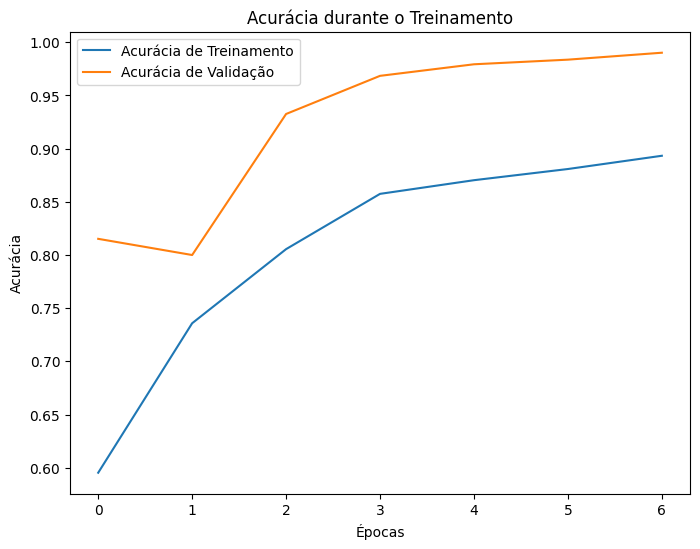

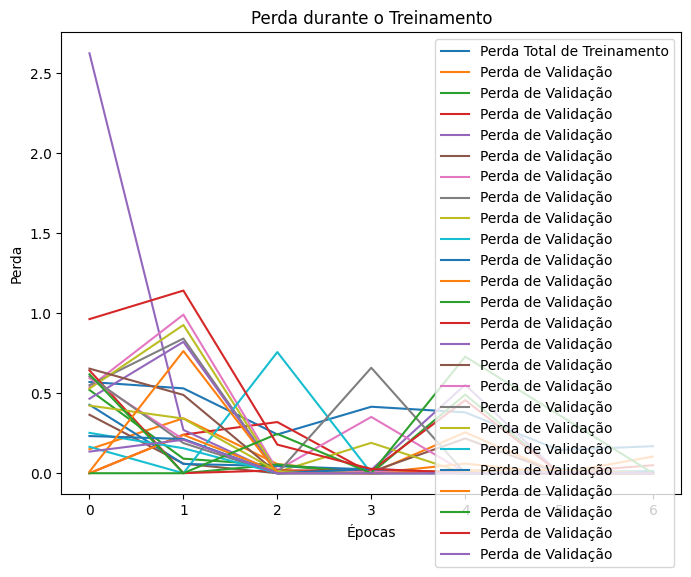

In [ ]:
#plotando os graficos
# Gráfico de Acurácia
plt.figure(figsize=(8, 6))
plt.plot(history6.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history6.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.savefig('Graficoacuracia6')
plt.show()

# Gráfico de Perda
plt.figure(figsize=(8, 6))
plt.plot(history6.history['total_loss'], label='Perda Total de Treinamento')
plt.plot(history6.history['val_label_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.savefig('Graficoperda6')
plt.show()


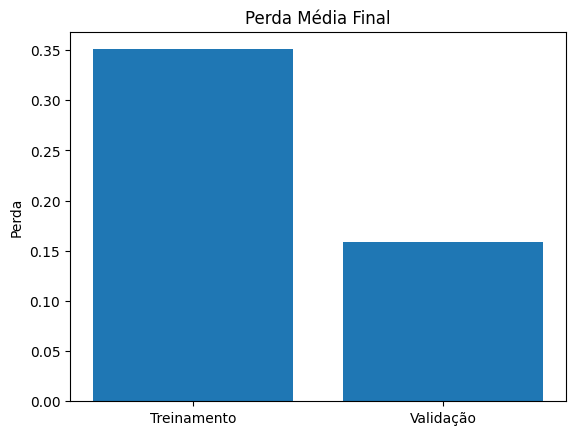

In [ ]:
import matplotlib.pyplot as plt

# Calcular perda média final
final_train_loss = np.mean(history6.history['total_loss'][-10:])
final_val_loss = np.mean(history6.history['val_label_loss'][-10:])

# Gráfico de Barras
plt.bar(['Treinamento', 'Validação'], [final_train_loss, final_val_loss])
plt.title('Perda Média Final')
plt.ylabel('Perda')
plt.savefig('Graficoloss6')
plt.show()
